## Find VK groups with common subscribers (with threshold 500k–1kk users) 
We've already got **users subscriptions** (with threshold for number of participants from **500k to 1kk**).

In [440]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import collections
from collections import Counter
from tqdm import tqdm
from heapq import nlargest

In [2]:
def from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)   

In [12]:
def to_pickle_groups(data, filename):
    with open(f'{filename}.pickle', 'wb') as f:
        return pickle.dump(data, f)

#### [jonathansoma](http://jonathansoma.com)  
[matplotlib fonts](http://jonathansoma.com/site/lede/data-studio/matplotlib/list-all-fonts-available-in-matplotlib-plus-samples/)  
[source-target graph tutorial](http://jonathansoma.com/lede/algorithms-2017/classes/networks/networkx-graphs-from-source-target-dataframe/)  

[graphs](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python)  [dash](https://towardsdatascience.com/python-interactive-network-visualization-using-networkx-plotly-and-dash-e44749161ed7)  [nx features manually](https://towardsdatascience.com/customizing-networkx-graphs-f80b4e69bedf)

[networkx presentation](http://www.mi-ras.ru/~sk/lehre/dm_hse/01_NetworkX.pdf)  
[weights](https://stackoverflow.com/questions/52400380/assign-edge-weights-to-a-networkx-graph-using-pandas-dataframe)  
[color](https://www.python-graph-gallery.com/324-map-a-color-to-network-nodes)

## Make pairs

In [7]:
all_groups = from_pickle('all_groups_info.pickle')

In [9]:
print('Количество пользователей, по которым собраны группы:', len(all_groups))

Количество пользователей, по которым собраны группы: 2507443


In [10]:
##work wit train dictionary subset
#train = {k: v for k, v in all_groups.items() if len(str(k)) == 3}

In [65]:
def all_possible_pairs(dictionary):
    all_possible_pairs = []
    for val in tqdm(dictionary.values()):
        if val:
            pair_subset = ([(min(val[i], val[j]), 
                             max((val[i], val[j]))) 
                             for i in range(len(val)) 
                             for j in range(i+1, len(val))])
            
        all_possible_pairs.extend(pair_subset)
    
    print('Количество всех возможных пар:',len(all_possible_pairs))
    #with open('GROUPS_PAIRS_to_DF/1_all_possible_pairs.pickle', 'wb') as f:
        #pickle.dump(all_possible_pairs, f)
    
    counts = Counter(all_possible_pairs).most_common()
    print('Количество уникальных пар:',len(counts))
    
    return all_possible_pairs, counts

In [66]:
all_pairs, all_pairs_count = all_possible_pairs(all_groups)

100%|██████████| 2507443/2507443 [05:05<00:00, 8204.22it/s] 


Количество всех возможных пар: 490573852
Количество уникальных пар: 1575863


In [68]:
# with open('GROUPS_PAIRS_to_DF/count_pairs.pickle', 'wb') as f:
#     pickle.dump(all_pairs_count, f)

In [70]:
def make_df(counts):
    ##extract nested tuples
    unpacked = [(x, y, z) for ((x, y), z) in counts]
    
    ##make DataFrame from the list with nodes and weight
    df_nodes = pd.DataFrame(unpacked, columns=['node1', 'node2', 'weight'])
    
    print('Количество пар вершин (ребер):',df_nodes.shape[0])
    return df_nodes

In [71]:
pairs_count_df = make_df(all_pairs_count)

Количество пар вершин (ребер): 1575863


In [72]:
# pairs_count_df.to_pickle('GROUPS_PAIRS_to_DF/count_pairs+_df.pickle')

# Add table with groups info

In [89]:
pairs_info_df = pd.read_pickle('GROUPS_PAIRS_to_DF/GROUPS_info_df.pickle')

In [93]:
pairs_info_df.head(2)

,group_id,name,type,activity,members,status,verified
0,31457299,Анаболизм Машин | Силовой спорт | Качалка,page,Спортивная организация,572167,,0
1,41,Одержимые футболом,page,Футбол,554339,🔥 Все о футболе,0


### Add a suffix to duplicated names

In [112]:
#some groups names are the same
#we need to add some marks to differ groups names
duplicated = pairs_info_df[pairs_info_df.duplicated(['name'])]
print('Количество одинаковых названий групп:',len(duplicated))

Количество одинаковых названий групп: 58


In [94]:
#set names as index
df = pairs_info_df.set_index('name')

In [98]:
df.index

Index(['Анаболизм Машин | Силовой спорт | Качалка', 'Одержимые футболом',
       'AORUS', 'СПАЛИЛИ', 'Я женщина, мама, хозяйка, жена| Рецепты здоровья',
       'iScience - наука и образование!',
       'Прогнозы на спорт | Live от Fuckbet', 'NESCAFE', 'Киберспорт CS:GO',
       'Голый Пистолет',
       ...
       'Мужские Мысли', 'Книги & Аудиокниги', 'Sin Psychology',
       'Книга Великих Мыслей', 'Бизнес, успех, мотивация. Умный журнал.',
       'Бабушкины Рецепты', 'Кайфовая юность', 'ФИАСКО', 'к тебе хочу. очень',
       'Пацанское дело | МУЖСКОЙ КЛУБ'],
      dtype='object', name='name', length=2295)

In [99]:
#find duplicated names and remove of duplicated index to unique (group, group1, group2...)
df.index = df.index + df.groupby(level=0).cumcount().astype(str).replace('0','')

In [465]:
df[df.index.str.match('PHARAOH')]

,group_id,type,activity,members,status,verified
PHARAOH,63530169,page,Творчество,918842,million dollar depression,1


In [111]:
#changed!
df[df.index.str.match('Рецепты')] #PHARAOH
#df[df.index.str.contains("Рецепты")]

,group_id,type,activity,members,status,verified
Рецепты,26740020,page,"Кулинария, рецепты",737862,Присоединяйся ;),0
Рецепты для мультиварки |Кулинария |Мультиварка,43706510,page,"Кулинария, рецепты",593086,Вкусные рецепты для мультиварки! Новые рецепты...,0
Рецепты на каждый день от кулинаров на RUtxt.ru,30656667,group,Открытая группа,768250,"Вкусно, просто, быстро! Пошаговые фоторецепты ...",0
Рецепты1,36105203,page,Творческое объединение,949850,"🍴 Только самое вкусное! Добавь на стенку, чтоб...",0
Рецепты2,33337763,group,Открытая группа,687540,Официальная группа кулинарного сайта Поварёнок...,0
Рецепты правильного питания,94098607,page,Здоровый образ жизни,557399,🍓,0
Рецепты3,39130500,page,"Кулинария, рецепты",568426,"Мы любим готовить вкусно, красиво и быстро! 🍒",0
"Рецепты ПП: правильное питание, диетические",72350250,page,"Кулинария, рецепты",753627,"Всё о правильном питании: рецепты, диеты, раци...",0


### Make dictionary from groups ids and new names

In [113]:
ids_names_dict = pd.Series(df.index.values,index=df.group_id).to_dict()

### Replace old ids-nodes with groups names

In [115]:
pairs_count_df = pd.read_pickle('GROUPS_PAIRS_to_DF/count_pairs+_df.pickle')

In [116]:
pairs_count_df.sample(3)

,node1,node2,weight
539424,141103326,149798390,13
1542269,40771265,178045303,1
745696,26170853,51073679,8


In [464]:
pairs_count_df.head()

,node1,node2,weight
0,26813657,30314549,1069380
1,30314549,63530169,1069371
2,30314549,42923159,1069354
3,111869067,124002407,1069354
4,30314549,114454317,1069351


In [118]:
#replace ids with names
pairs_count_df_ = pairs_count_df.replace({'node1':ids_names_dict, 
                                          'node2':ids_names_dict})

In [120]:
#normalize values in 'weight' column
pairs_count_df_['norm_weight_min_max'] =  ((pairs_count_df_['weight'] 
                                            - pairs_count_df_['weight'].min())
                                            / (pairs_count_df_['weight'].max()
                                            - pairs_count_df_['weight'].min()))


#(df-df.min())/(df.max()-df.min())

In [121]:
pairs_count_df_

,node1,node2,weight,norm_weight_min_max
0,Весы 19 апреля,ЛСП,1069380,1.000000
1,ЛСП,PHARAOH,1069371,0.999992
2,ЛСП,MRZLK,1069354,0.999976
3,я смотрю украинские шоу и радуюсь жизни,самый сок,1069354,0.999976
4,ЛСП,ПОШЛАЯ МОЛЛИ,1069351,0.999973
...,...,...,...,...
1575858,Avon Россия,EDM Trap Music,1,0.000000
1575859,Avon Россия,ПАЦАНЫ И ЭНЕРГЕТИКИ,1,0.000000
1575860,НОВИНКИ МУЗЫКИ 2021,ПАЦАНЫ И ЭНЕРГЕТИКИ,1,0.000000
1575861,Школа техник Наруто,twenty one pictures,1,0.000000


In [123]:
#DataFrame with caracteristics for nodes
df.sample(3)

,group_id,type,activity,members,status,verified
ФУТБОЛ I ТРАНСФЕРЫ,47035313,page,Футбол,551805,Трансферное окно закрыто 🤙,0
Добрые мемы (• ◡•),147286578,page,Юмор,884717,Добрый паблик : ),0
"Цени, а не оценивай",61050845,page,Юмор,706035,Заходи! :),0


In [125]:
# #save these two tables
# pairs_count_df_.to_pickle('GRAPH/nodes_weights.pickle')
# df.to_pickle('GRAPH/nodes_carac.pickle')

## Build and plot graph

### Filter table with groups pairs

In [549]:
nodes = pd.read_pickle('GRAPH/nodes_weights.pickle')
carac = pd.read_pickle('GRAPH/nodes_carac.pickle')

In [550]:
#filter table with nodes
##keep the most common pairs (with more than 5k occurances) 
nodes_ = nodes[nodes.weight > 5000]

In [551]:
#got 604 pairs
nodes_

,node1,node2,weight,norm_weight_min_max
0,Весы 19 апреля,ЛСП,1069380,1.000000
1,ЛСП,PHARAOH,1069371,0.999992
2,ЛСП,MRZLK,1069354,0.999976
3,я смотрю украинские шоу и радуюсь жизни,самый сок,1069354,0.999976
4,ЛСП,ПОШЛАЯ МОЛЛИ,1069351,0.999973
...,...,...,...,...
599,1000 фактов,Мода - СТИЛЬНЫЕ ВЕЩИ,47580,0.044492
600,Скотч,Мода - СТИЛЬНЫЕ ВЕЩИ,47580,0.044492
601,Скотч,Умелые ручки,47580,0.044492
602,Мода - СТИЛЬНЫЕ ВЕЩИ,Умелые ручки,47580,0.044492


### Add extra info to the ceracteristics table

In [552]:
carac.head(2)

,group_id,type,activity,members,status,verified
Анаболизм Машин | Силовой спорт | Качалка,31457299,page,Спортивная организация,572167,,0
Одержимые футболом,41,page,Футбол,554339,🔥 Все о футболе,0


In [553]:
#normalize values in 'weight' column
carac['norm_members_min_max'] =  ((carac['members'] 
                                - carac['members'].min())
                                / (carac['members'].max()
                                - carac['members'].min()))

# Build a graph

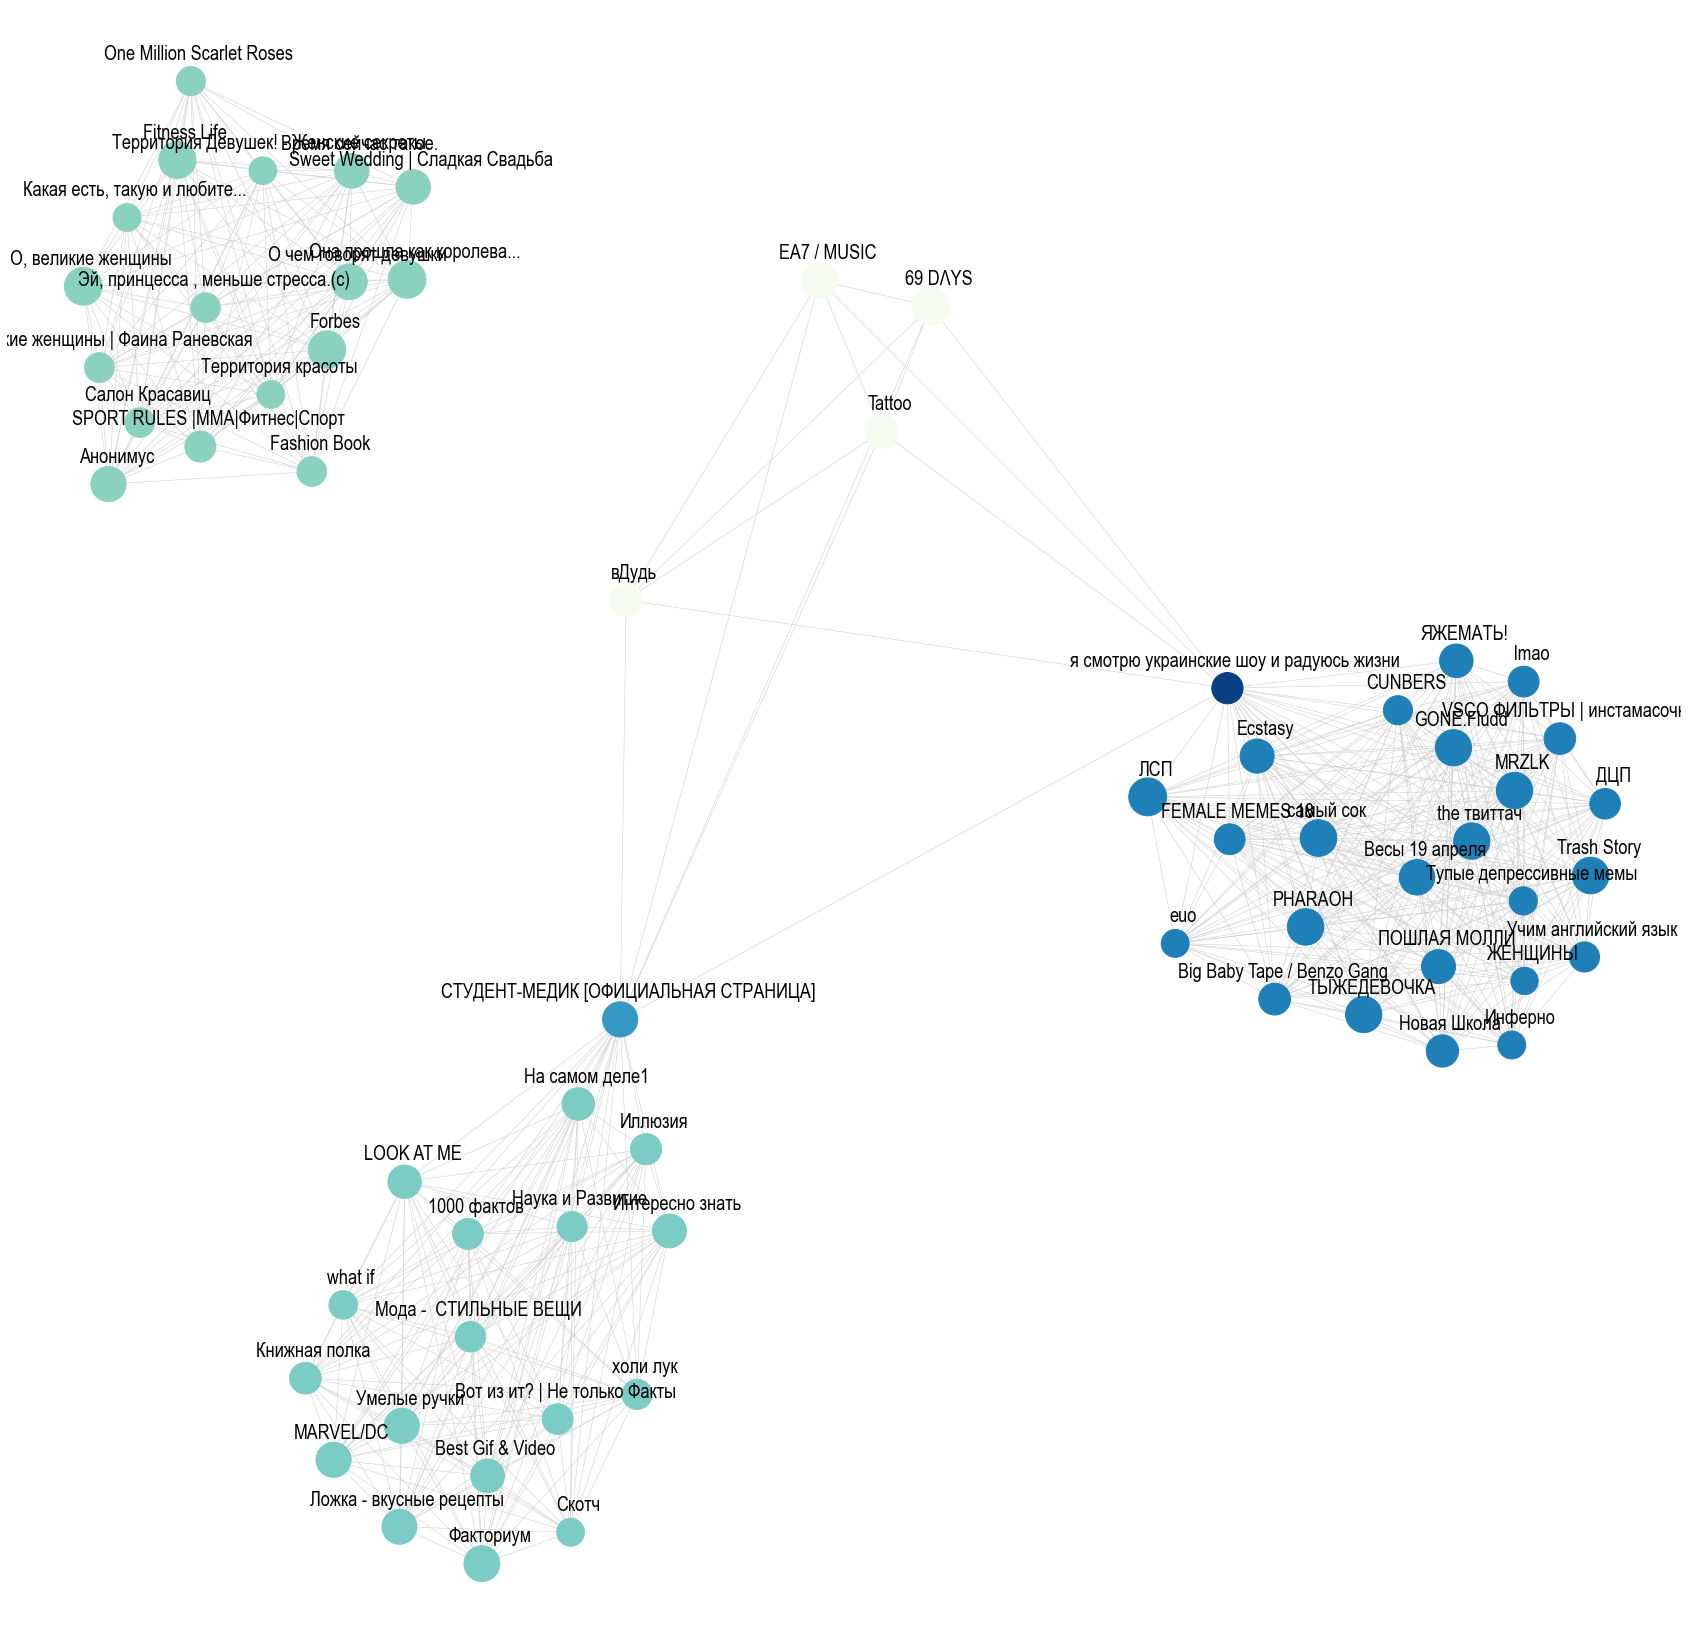

In [574]:
#figsize: width, height
#dpi default: 100

plt.figure(figsize=(30,30),facecolor='white')

#create layout 
##k-скученность (больше число-больше расстояние между нодами)
##iterations-отдаленность кластеров
layout = nx.spring_layout(g,iterations=30,k=0.55) #k=0.35


carac = carac.reindex(g.nodes())
#create the graph
g = nx.from_pandas_edgelist(nodes_,'node1','node2',
                            edge_attr='norm_weight_min_max',
                            create_using=nx.Graph())


#set nodes colors according to their degree
degrees = g.degree()      
nodes = g.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

#draw every node
nx.draw_networkx_nodes(g,layout, 
                       nodelist=nodes, 
                       node_color=n_color,
                       cmap=plt.cm.GnBu, #YlGnBu 
                       node_size=carac.norm_members_min_max * 1500)


#draw edges
frequency = ([i['norm_weight_min_max'] 
             for i in dict(g.edges).values()])

nx.draw_networkx_edges(g,layout, 
                       edge_color='#cccccc',#'#8F8F8F', 
                       width=0.5) #frequency

#draw labels
#raise text positions
for l in layout:  
    layout[l][0] += 0.01 #правее
    layout[l][1] += 0.03 #выше
nx.draw_networkx_labels(g,layout,
                        font_size=20,
                        font_family='Arial Narrow')


#turn off the axis
plt.axis('off')
#plt.savefig('GRAPH/groups_graph.svg')
plt.show()

###  Sort nodes by degree

In [491]:
degrees_list = sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True)

In [493]:
degrees_list[:5]

[('я смотрю украинские шоу и радуюсь жизни', 29),
 ('Весы 19 апреля', 24),
 ('ЛСП', 24),
 ('PHARAOH', 24),
 ('MRZLK', 24)]

### Центральность по степени (degree centrality)
Паблик с высоким значением degree_centrality чаще всего встречается вместе с остальными пабликами в подписках группы пользователей  
__degree_centrality__ тем выше, чем больше число связей вершины с другими вершинами в графе  
[центральности](http://asocialnetworks.blogspot.com/2016/02/python-networkx.html)

In [488]:
#compute the degree centrality & print 5 nodes with maximum degree centrality
dcent = nx.degree_centrality(g)
sorted(dcent.items(), key=lambda item: item[1], reverse=True)[:5]

#five_largest = nlargest(5, dcent, key=dcent.get)

[('я смотрю украинские шоу и радуюсь жизни', 0.4603174603174603),
 ('Весы 19 апреля', 0.38095238095238093),
 ('ЛСП', 0.38095238095238093),
 ('PHARAOH', 0.38095238095238093),
 ('MRZLK', 0.38095238095238093)]

### Центральность по посредничеству (betweenness centrality)
betweenness показывает, как часто пользователь подписывался на тот или иной паблик, "бродя" по другим тематическим пабликамю. Или на какой паблик чаще всего ссылаются (репостят записи) другие

In [489]:
#compute betweenness centrality
bcent = nx.betweenness_centrality(g)
sorted(bcent.items(), key=lambda item: item[1], reverse=True)[:5]

[('я смотрю украинские шоу и радуюсь жизни', 0.27035330261136714),
 ('СТУДЕНТ-МЕДИК [ОФИЦИАЛЬНАЯ СТРАНИЦА]', 0.2524321556579621),
 ('Весы 19 апреля', 0.0),
 ('ЛСП', 0.0),
 ('PHARAOH', 0.0)]

### Центральность по собственному вектору (eigenvector centrality)
мера оценки популярности паблика. Этот индекс может сказать нам, что, хотя некоторые паблики в сети имеют большое число связей, они не так важны, как другие с гораздо меньшим числом связей. В нашем случае паблики по eigenvector centrality и degree centrality совпадают

In [555]:
#print 5 nodes with maximum eigenvector centrality
eigcent = nx.eigenvector_centrality(g, max_iter=600)
sorted(eigcent.items(), key=lambda item: item[1], reverse=True)[:5]

[('я смотрю украинские шоу и радуюсь жизни', 0.20192507044163713),
 ('Весы 19 апреля', 0.1998603151583379),
 ('ЛСП', 0.1998603151583379),
 ('PHARAOH', 0.1998603151583379),
 ('MRZLK', 0.1998603151583379)]

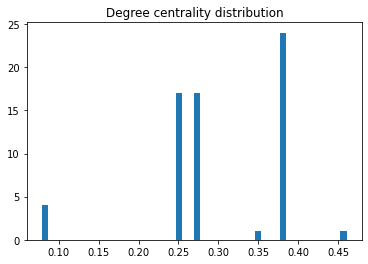

In [405]:
#print histogram with centralities distribution
plt.figure()
plt.hist(list(dcent.values()),bins = 50)
plt.title('Degree centrality distribution')
plt.show()

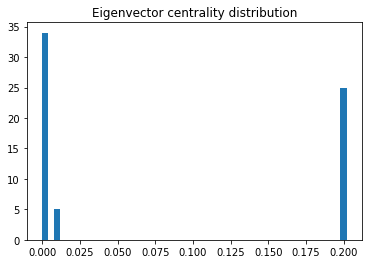

In [407]:
plt.figure()
plt.hist(list(eigcent.values()),bins = 50)
plt.title('Eigenvector centrality distribution')
plt.show()